
# Write DICOM data

This example shows how to write a DICOM file from scratch using pydicom. This
example does not produce a DICOM standards compliant file as written, you will
have to change UIDs to valid values and add all required DICOM data elements.


In [7]:
# authors : Guillaume Lemaitre <g.lemaitre58@gmail.com>
# license : MIT

import datetime
import os
import tempfile

import pydicom
from pydicom.dataset import FileDataset, FileMetaDataset
from pydicom.uid import UID

# Create some temporary filenames
suffix = '.dcm'
filename_little_endian = tempfile.NamedTemporaryFile(suffix=suffix).name
filename_big_endian = tempfile.NamedTemporaryFile(suffix=suffix).name

print("Setting file meta information...")
# Populate required values for file meta information
file_meta = FileMetaDataset()
file_meta.MediaStorageSOPClassUID = UID('1.2.840.10008.5.1.4.1.1.2')
file_meta.MediaStorageSOPInstanceUID = UID("1.2.3")
file_meta.ImplementationClassUID = UID("1.2.3.4")

print("Setting dataset values...")
# Create the FileDataset instance (initially no data elements, but file_meta
# supplied)
ds = FileDataset(filename_little_endian, {},
                 file_meta=file_meta, preamble=b"\0" * 128)

# Add the data elements -- not trying to set all required here. Check DICOM
# standard
ds.PatientName = "Test^Firstname"
ds.PatientID = "123456"

# Set the transfer syntax
ds.is_little_endian = True
ds.is_implicit_VR = True

# Set creation date/time
dt = datetime.datetime.now()
ds.ContentDate = dt.strftime('%Y%m%d')
timeStr = dt.strftime('%H%M%S.%f')  # long format with micro seconds
ds.ContentTime = timeStr

print("Writing test file", filename_little_endian)
ds.save_as(filename_little_endian)
print("File saved.")

# Write as a different transfer syntax XXX shouldn't need this but pydicom
# 0.9.5 bug not recognizing transfer syntax
ds.file_meta.TransferSyntaxUID = pydicom.uid.ExplicitVRBigEndian
ds.is_little_endian = False
ds.is_implicit_VR = False

print("Writing test file as Big Endian Explicit VR", filename_big_endian)
ds.save_as(filename_big_endian)

# # reopen the data just for checking
# for filename in (filename_little_endian, filename_big_endian):
#     print('Load file {} ...'.format(filename))
#     ds = pydicom.dcmread(filename)
#     print(ds)

#     # remove the created file
#     print('Remove file {} ...'.format(filename))
#     os.remove(filename)




Setting file meta information...
Setting dataset values...
Writing test file C:\Users\mot99\AppData\Local\Temp\tmp49tfy6z6.dcm
File saved.
Writing test file as Big Endian Explicit VR C:\Users\mot99\AppData\Local\Temp\tmpp3h_68al.dcm


In [12]:
import pydicom
from pydicom.dataset import Dataset, FileDataset
from pydicom.uid import ExplicitVRLittleEndian
import pydicom._storage_sopclass_uids
import numpy as np


x = np.arange(16).reshape(16,1)
pixel_array = (x + x.T) * 32
pixel_array = np.tile(pixel_array,(1,1))

image2d = pixel_array.astype(np.uint16)

print("Setting file meta information...")
# Populate required values for file meta information

meta = pydicom.Dataset()
meta.MediaStorageSOPClassUID = pydicom._storage_sopclass_uids.MRImageStorage
meta.MediaStorageSOPInstanceUID = pydicom.uid.generate_uid()
meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian  

ds = Dataset()
ds.file_meta = meta

ds.is_little_endian = True
ds.is_implicit_VR = False

ds.SOPClassUID = pydicom._storage_sopclass_uids.MRImageStorage
ds.PatientName = "Test^Firstname"
ds.PatientID = "123456"

ds.Modality = "MR"
ds.SeriesInstanceUID = pydicom.uid.generate_uid()
ds.StudyInstanceUID = pydicom.uid.generate_uid()
ds.FrameOfReferenceUID = pydicom.uid.generate_uid()

ds.BitsStored = 16
ds.BitsAllocated = 16
ds.SamplesPerPixel = 1
ds.HighBit = 15

ds.ImagesInAcquisition = "1"

ds.Rows = image2d.shape[0]
ds.Columns = image2d.shape[1]
ds.InstanceNumber = 1

ds.ImagePositionPatient = r"0\0\1"
ds.ImageOrientationPatient = r"1\0\0\0\-1\0"
ds.ImageType = r"ORIGINAL\PRIMARY\AXIAL"

ds.RescaleIntercept = "0"
ds.RescaleSlope = "1"
ds.PixelSpacing = r"1\1"
ds.PhotometricInterpretation = "MONOCHROME2"
ds.PixelRepresentation = 1

pydicom.dataset.validate_file_meta(ds.file_meta, enforce_standard=True)

print("Setting pixel data...")
ds.PixelData = image2d.tobytes()

ds.save_as(r"out.dcm")

Setting file meta information...
Setting pixel data...



File path........: ../data/dicom/real/f6c843ac-5b9f-4486-a4b8-3ecbb88e2e2c.dcm
SOP Class........: 1.2.840.10008.5.1.4.1.1.2 (CT Image Storage)

P100
Patient's Name...: P100, 
Patient ID.......: 100_HM10395
Modality.........: CT
Study Date.......: 19971028
Image size.......: 512 x 512
Pixel Spacing....: [0.878906, 0.878906]
Slice location...: 64.500000


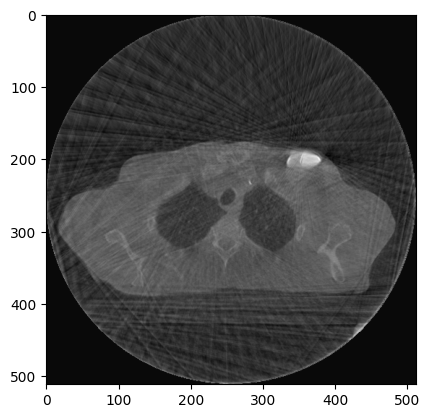

In [24]:
import matplotlib.pyplot as plt
from pydicom import dcmread
from pydicom.data import get_testdata_file

# read input image
fpath = '../data/dicom/real/f6c843ac-5b9f-4486-a4b8-3ecbb88e2e2c.dcm'
ds = dcmread(fpath)

# Normal mode:
print()
print(f"File path........: {fpath}")
print(f"SOP Class........: {ds.SOPClassUID} ({ds.SOPClassUID.name})")
print()

pat_name = ds.PatientName
print(pat_name)
print(f"Patient's Name...: {pat_name.family_comma_given()}")
print(f"Patient ID.......: {ds.PatientID}")
print(f"Modality.........: {ds.Modality}")
print(f"Study Date.......: {ds.StudyDate}")
print(f"Image size.......: {ds.Rows} x {ds.Columns}")
print(f"Pixel Spacing....: {ds.PixelSpacing}")

# use .get() if not sure the item exists, and want a default value if missing
print(f"Slice location...: {ds.get('SliceLocation', '(missing)')}")


ds.save_as(r"out.dcm")
# plot the image using matplotlib
plt.imshow(ds.pixel_array, cmap=plt.cm.gray)
plt.show()

In [110]:
import random

def create_volume(input_fpath='../data/dicom/real/104_HM10395 P104/2819497684894126 p4/CT P4 P104 S106 I0 Gated 80.0',
                  output_fpath='../data/dicom/random/test1/'):

  _PatientName = 'Max Muster'
  _PatientID = '100_HM10000'
  _SeriesInstanceUID = pydicom.uid.generate_uid()
  _StudyInstanceUID = pydicom.uid.generate_uid()
  _SeriesDescription = 'There is pneumonia. '


  for i in range(50):
    # copy 50 text images
    fpath = input_fpath + "/CT" + ((6-len(str(i)))*"0" +str(i))+".dcm"
    print(fpath)
    ds = dcmread(fpath)

    # modify metadata
    ds.PatientName = _PatientName
    ds.PatientID = _PatientID
    ds.SeriesInstanceUID = _SeriesInstanceUID
    ds.StudyInstanceUID = _StudyInstanceUID
    ds.SeriesDescription = _SeriesDescription
    ds.FrameOfReferenceUID = pydicom.uid.generate_uid()
    ds.SeriesNumber = '1'
    
    ds.StudyDate='20240430'
    ds.SliceLocation = str(i)

    # image size is 512x512, values from -2000,0

    # modify image
    for j in range(ds.Rows):
      for k in range(ds.Columns):

        if (j-200)**2 +(k-200)**2  + (ds.InstanceNumber -25)**2<= 10**2: # a spehere with radius 
          ds.pixel_array[j,k] = random.randint(0, 500)

      ds.PixelData = ds.pixel_array.tobytes() # write changes back to pixel data
      
    ds.save_as(output_fpath +"out"+str(i)+".dcm")
    # plt.imshow(ds.pixel_array, cmap=plt.cm.gray)
    # plt.show()

create_volume()

../data/dicom/real/104_HM10395 P104/2819497684894126 p4/CT P4 P104 S106 I0 Gated 80.0/CT000000.dcm
../data/dicom/real/104_HM10395 P104/2819497684894126 p4/CT P4 P104 S106 I0 Gated 80.0/CT000001.dcm
../data/dicom/real/104_HM10395 P104/2819497684894126 p4/CT P4 P104 S106 I0 Gated 80.0/CT000002.dcm
../data/dicom/real/104_HM10395 P104/2819497684894126 p4/CT P4 P104 S106 I0 Gated 80.0/CT000003.dcm
../data/dicom/real/104_HM10395 P104/2819497684894126 p4/CT P4 P104 S106 I0 Gated 80.0/CT000004.dcm
../data/dicom/real/104_HM10395 P104/2819497684894126 p4/CT P4 P104 S106 I0 Gated 80.0/CT000005.dcm
../data/dicom/real/104_HM10395 P104/2819497684894126 p4/CT P4 P104 S106 I0 Gated 80.0/CT000006.dcm
../data/dicom/real/104_HM10395 P104/2819497684894126 p4/CT P4 P104 S106 I0 Gated 80.0/CT000007.dcm
../data/dicom/real/104_HM10395 P104/2819497684894126 p4/CT P4 P104 S106 I0 Gated 80.0/CT000008.dcm
../data/dicom/real/104_HM10395 P104/2819497684894126 p4/CT P4 P104 S106 I0 Gated 80.0/CT000009.dcm
../data/di

In [58]:
ds.pixel_array.max()

3548

In [1]:
# authors : Guillaume Lemaitre <g.lemaitre58@gmail.com>
# license : MIT

import datetime
import os
import tempfile

import pydicom
from pydicom.dataset import FileDataset, FileMetaDataset
from pydicom.uid import UID

# Create some temporary filenames
suffix = '.dcm'
filename_little_endian = tempfile.NamedTemporaryFile(suffix=suffix).name
filename_big_endian = tempfile.NamedTemporaryFile(suffix=suffix).name

print("Setting file meta information...")
# Populate required values for file meta information
file_meta = FileMetaDataset()
file_meta.MediaStorageSOPClassUID = UID('1.2.840.10008.5.1.4.1.1.2')
file_meta.MediaStorageSOPInstanceUID = UID("1.2.3")
file_meta.ImplementationClassUID = UID("1.2.3.4")

print("Setting dataset values...")
# Create the FileDataset instance (initially no data elements, but file_meta
# supplied)
ds = FileDataset(filename_little_endian, {},
                 file_meta=file_meta, preamble=b"\0" * 128)

# Add the data elements -- not trying to set all required here. Check DICOM
# standard
ds.PatientName = "Test^Firstname"
ds.PatientID = "123456"

# Set the transfer syntax
ds.is_little_endian = True
ds.is_implicit_VR = True

# Set creation date/time
dt = datetime.datetime.now()
ds.ContentDate = dt.strftime('%Y%m%d')
timeStr = dt.strftime('%H%M%S.%f')  # long format with micro seconds
ds.ContentTime = timeStr

print("Writing test file", filename_little_endian)
ds.save_as(filename_little_endian)
print("File saved.")

# Write as a different transfer syntax XXX shouldn't need this but pydicom
# 0.9.5 bug not recognizing transfer syntax
ds.file_meta.TransferSyntaxUID = pydicom.uid.ExplicitVRBigEndian
ds.is_little_endian = False
ds.is_implicit_VR = False

print("Writing test file as Big Endian Explicit VR", filename_big_endian)
ds.save_as(filename_big_endian)

# reopen the data just for checking
for filename in (filename_little_endian, filename_big_endian):
    print('Load file {} ...'.format(filename))
    ds = pydicom.dcmread(filename)
    print(ds)

    # remove the created file
    print('Remove file {} ...'.format(filename))
    os.remove(filename)

Setting file meta information...
Setting dataset values...
Writing test file C:\Users\mot99\AppData\Local\Temp\tmpx8phsuor.dcm
File saved.
Writing test file as Big Endian Explicit VR C:\Users\mot99\AppData\Local\Temp\tmpq12hom53.dcm
Load file C:\Users\mot99\AppData\Local\Temp\tmpx8phsuor.dcm ...
Dataset.file_meta -------------------------------
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.3
(0002, 0012) Implementation Class UID            UI: 1.2.3.4
-------------------------------------------------
(0008, 0023) Content Date                        DA: '20240429'
(0008, 0033) Content Time                        TM: '173703.317973'
(0010, 0010) Patient's Name                      PN: 'Test^Firstname'
(0010, 0020) Patient ID                          LO: '123456'
Remove file C:\Users\mot99\AppData\Local\Temp\tmpx8phsuor.dcm ...
Load file C:\Users\mot99\AppData\Local\Temp\tmpq12hom53.dcm ...
Dataset.file_meta 